# General EDA

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import rasterio
import geopandas as geopd
import rasterio.rio
import seaborn as sns
import datetime as dt 

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


from rasterio.plot import show

import pyreadr

RSEED = 42



First, we import the final dataframes.

In [2]:
df_all = geopd.read_file("../data/final_shapefiles/foxes_modelling_all.shp")
df_resamp = geopd.read_file("../data/final_shapefiles/foxes_modelling_resamp.shp")
#sample_points = geopd.read_file("../data/cleaned_shapefiles/sample_points.shp")

## Create dummie variables
### Bin aspect feature
First, we put the aspect feature into bins. One bin for the -1 values (where the slope is zero) and eight bins for the eight geographic directions.

### Create dummie variables for all categorical variables

In [3]:
cat_variables = ["soil", "veg", "aspect_bin"]

In [4]:
df_all_enc = df_all.drop(["veg", "soil"], axis = 1)
df_resamp_enc = df_resamp.drop(["veg", "soil"], axis = 1)

In [5]:
df_all_enc.head()

,x_,y_,t_,id,sex,NDVI,NDMI,slope,aspect,elev,...,veg_Water,asp_N,asp_NE,asp_E,asp_SE,asp_S,asp_SW,asp_W,asp_NW,geometry
0,548522.717454,7.353167e+06,2018-07-10-01:56:30,2018-FSBD608-001,F,0.662722,0.125608,10.135784,205.492111,1033.016602,...,0,0,0,0,0,0,1,0,0,POINT (548522.717 7353166.639)
1,548525.680513,7.353168e+06,2018-07-10-06:56:32,2018-FSBD608-001,F,0.662722,0.125608,10.135784,205.492111,1033.016602,...,0,0,0,0,0,0,1,0,0,POINT (548525.681 7353168.363)
2,548539.963810,7.353164e+06,2018-07-10-11:56:32,2018-FSBD608-001,F,0.662722,0.125608,10.135784,205.492111,1033.016602,...,0,0,0,0,0,0,1,0,0,POINT (548539.964 7353164.150)
3,548195.507163,7.352493e+06,2018-07-10-22:31:11,2018-FSBD608-001,F,0.443307,-0.138425,10.065748,339.629059,1072.429321,...,0,1,0,0,0,0,0,0,0,POINT (548195.507 7352493.197)
4,548558.891944,7.352589e+06,2018-07-11-13:31:01,2018-FSBD608-001,F,0.504280,-0.113833,12.232175,6.898972,1056.955200,...,0,1,0,0,0,0,0,0,0,POINT (548558.892 7352588.648)


In [6]:
df_all_enc.columns

Index(['x_', 'y_', 't_', 'id', 'sex', 'NDVI', 'NDMI', 'slope', 'aspect',
       'elev', 'timestamp', 'area', 'target', 'distForest', 'soil_Peat(',
       'soil_Rest', 'soil_Roesb', 'soil_Stone', 'soil_Water', 'veg_Bush',
       'veg_Dry Sh', 'veg_Grassl', 'veg_Moist', 'veg_Snow', 'veg_Stone',
       'veg_Water', 'asp_N', 'asp_NE', 'asp_E', 'asp_SE', 'asp_S', 'asp_SW',
       'asp_W', 'asp_NW', 'geometry'],
      dtype='object')

## Start of Correlation Analysis

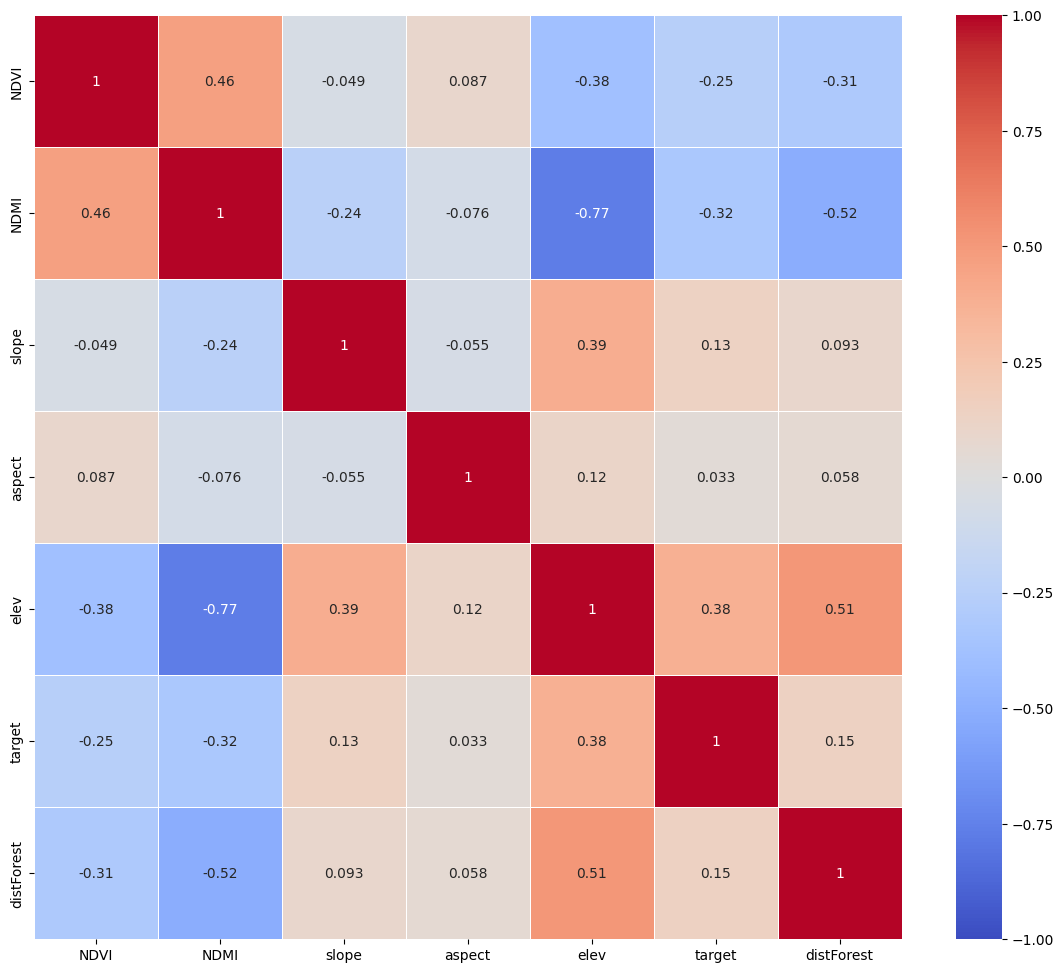

In [7]:
corr_columns = ["NDVI", "NDMI", "slope", "aspect", "elev", "target", "distForest"]

corr_all = df_all_enc[corr_columns].corr()
# corr_all = df_all_enc.corr()

plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_all, linewidths=.5, annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
# ax = sns.heatmap(corr_all, linewidths=.5, cmap='coolwarm', vmin = -1, vmax = 1)

In [8]:
df_query = df_all.query("aspect_bin == 'Flat'")
df_query.groupby("veg").count()

UndefinedVariableError: name 'aspect_bin' is not defined

In [9]:
df_query = df_all.query("veg == 'Water'")
df_query.groupby("aspect_bin").count()["veg"]

KeyError: 'aspect_bin'

In [ ]:
df_all.iloc[:, -19:-1].columns

In [ ]:
#corr_columns_veg_soil = df_all.iloc[:, -19:-9].columns
corr_columns_veg_soil = ['soil_Rest', 'soil_Roesberg', 'soil_Stone', 'soil_Water', 'veg_Bush',
       'veg_Dry Shrub', 'veg_Grassland', 'veg_Moist Shrub', 'veg_Snow',
       'veg_Stone', 'veg_Water', 'aspect_bin_N', 'aspect_bin_NE',
       'aspect_bin_E', 'aspect_bin_SE', 'aspect_bin_S', 'aspect_bin_SW',
       'aspect_bin_W', "target"]

corr_all = df_all_enc[corr_columns_veg_soil].corr()
# corr_all = df_all_enc.corr()

plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_all, linewidths=.5, annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
# ax = sns.heatmap(corr_all, linewidths=.5, cmap='coolwarm', vmin = -1, vmax = 1)

In [ ]:
corr_resamp = df_resamp_enc[corr_columns].corr()
# corr_resamp = df_resamp_enc.corr()

plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_resamp, linewidths=.5, annot=True, cmap='coolwarm', vmin = -1, vmax = 1)
# ax = sns.heatmap(corr_resamp, linewidths=.5, cmap='coolwarm', vmin = -1, vmax = 1)

In [ ]:
df_all_pair = df_all_enc[corr_columns]
sns.pairplot(df_all_pair, hue = "target")

In [ ]:
ax = sns.histplot(data = df_all, x = "elev", hue = "target", stat = "proportion", common_norm = False, element = "poly")
ax.set(xlabel = "Elevation", title = "Elevation Distribution in Available (0) and Used (1) Areas")

In [ ]:
ax = sns.histplot(data = df_all, x = "NDMI", hue = "target", stat = "proportion", common_norm = False, element = "poly")
#ax.set(xlim = [-0.99, 1], ylim = [0, 0.05])
ax.set(title = "NDMI Distribution in Available (0) and Used (1) Areas")



In [ ]:
ax = sns.histplot(data = df_all, x = "NDVI", hue = "target", stat = "probability", common_norm = False, element = "poly")
ax.set(title = "NDVI Distribution in Available (0) and Used (1) Areas")



In [ ]:
sns.scatterplot(data = df_all, x = "NDMI", y = "elev")

In [ ]:
df_all.query("target == 1").describe()

In [ ]:
df_all.query("target == 0").describe()

In [ ]:
df_all.groupby(["target","veg"]).count()["soil"]

In [ ]:
df_all.aspect_bin

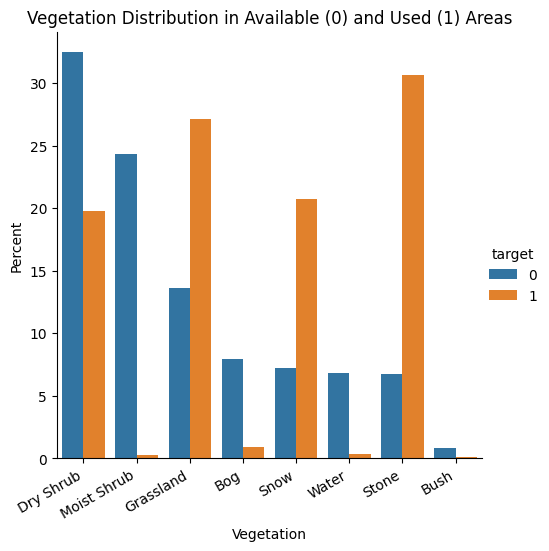

In [10]:
x,y = 'veg', 'target'

ax = (df_all
.groupby(y)[x]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
ax.set(xlabel = "Vegetation", ylabel = "Percent", title = "Vegetation Distribution in Available (0) and Used (1) Areas")
ax.set_xticklabels(rotation = 30, horizontalalignment = "right")

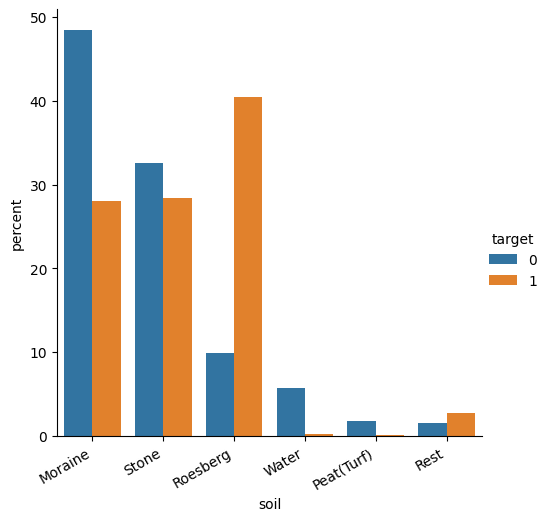

In [11]:
x,y = 'soil', 'target'

ax = (df_all
.groupby(y)[x]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
ax.set(xlabel = "soil")
ax.set_xticklabels(rotation = 30, horizontalalignment = "right")

In [12]:
df_all["aspect_bin_obj"] = df_all.aspect_bin.astype("object")

AttributeError: 'GeoDataFrame' object has no attribute 'aspect_bin'

In [ ]:
x,y = 'aspect_bin_obj', 'target'

ax = (df_all
.groupby(y)[x]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
ax.set(xlabel = "Aspect")
#ax.set_xticklabels(rotation = 30, horizontalalignment = "right")

In [ ]:
ax = sns.countplot(data = df_all, x = "veg", hue = "target")
ax.set(xlabel = "vegetation")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, horizontalalignment = "right")

None

<AxesSubplot:xlabel='soil', ylabel='count'>

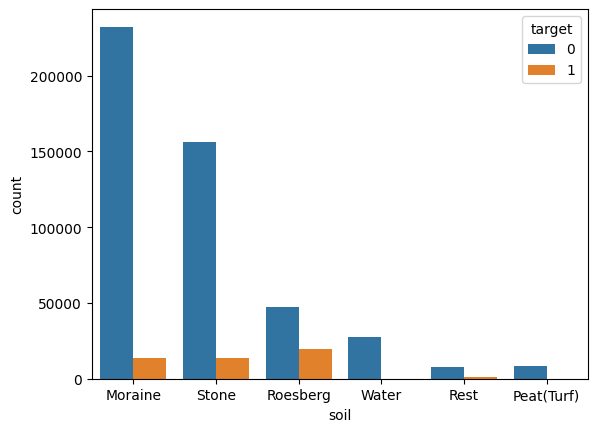

In [13]:
sns.countplot(data = df_all, x = "soil", hue = "target")


In [14]:
sns.countplot(data = df_all, x = "aspect_bin", hue = "target")


ValueError: Could not interpret input 'aspect_bin'

<AxesSubplot:xlabel='veg', ylabel='count'>

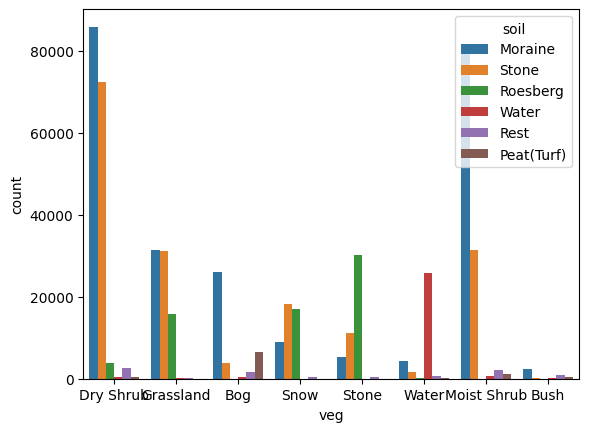

In [15]:
sns.countplot(data = df_all, x = "veg", hue = "soil")


## __Baseline Model__

In [ ]:
df_all_enc.aspect_bin

In [ ]:
X = df_all_enc.iloc[:,5:]
X = X.drop(["target", "geometry", "aspect_bin", "area", "timestamp"], axis = 1)
y = df_all["target"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = RSEED, test_size = 0.25)

In [ ]:
dsc_tree = DecisionTreeClassifier()
dsc_tree.fit(X_train, y_train)

y_pred_train = dsc_tree.predict (X_train)
y_pred = dsc_tree.predict(X_test)

In [ ]:
results = confusion_matrix(y_train, y_pred_train)
print(results)

In [ ]:
results_test = confusion_matrix(y_test, y_pred)
print(results_test)

In [ ]:
ax = sns.heatmap(results_test, annot = True, cmap = "Blues")
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))

In [ ]:
dsc_tree.feature_importances_

In [ ]:
feat_importances = pd.DataFrame(dsc_tree.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))